In [30]:
import pandas as pd
import urllib.request
import datetime as dt
import requests
import os
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
from haversine import haversine, Unit
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import pytz
from sklearn.metrics import accuracy_score
from sklearn.utils import class_weight
import numpy as np
from prettytable import PrettyTable
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix, classification_report
import glob
from statistics import mean

from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, RepeatedKFold
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.linear_model import SGDClassifier
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from numpy import mean, std
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from scipy.stats import zscore
import lightgbm as lgb

from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.utils import np_utils
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint


pd.set_option('display.max_columns', None)
p = print

## 1) Read in the Weather Data

In [2]:
# definte the processed and raw data directories
processed_data_dir = "../../data/processed/weather/"
raw_data_dir = "../../data/raw/"

In [3]:
weather_df = pd.read_csv(os.path.join(raw_data_dir, "weather_data", "weather_vectors_intrapolated.csv"))

In [4]:
weather_df.head()
# weather_df.shape

,image_name,air_temp_set_1,relative_humidity_set_1,wind_speed_set_1,wind_gust_set_1,wind_direction_set_1,dew_point_temperature_set_1d,u,v,fire_name
0,20190813_Topanga_69bravo-n-mobo/1565728842_-02400,-0.24240,0.29580,-1.43280,-1.37160,-0.495405,0.27720,-0.801122,0.283772,20190813_Topanga_69bravo-n-mobo
1,20190813_Topanga_69bravo-n-mobo/1565728902_-02340,-0.24678,0.29886,-1.42254,-1.38012,-0.489574,0.27522,-0.805174,0.279306,20190813_Topanga_69bravo-n-mobo
2,20190813_Topanga_69bravo-n-mobo/1565728962_-02280,-0.25116,0.30192,-1.41228,-1.38864,-0.483743,0.27324,-0.809226,0.274841,20190813_Topanga_69bravo-n-mobo
3,20190813_Topanga_69bravo-n-mobo/1565729022_-02220,-0.25554,0.30498,-1.40202,-1.39716,-0.477912,0.27126,-0.813278,0.270375,20190813_Topanga_69bravo-n-mobo
4,20190813_Topanga_69bravo-n-mobo/1565729082_-02160,-0.25992,0.30804,-1.39176,-1.40568,-0.472081,0.26928,-0.817330,0.265910,20190813_Topanga_69bravo-n-mobo


In [5]:
# read in camera metadata
# camera_metadata_df = pd.read_csv("../../data/processed/camera_metadata_hpwren.csv")
# read in camera metadata
camera_metadata_df = pd.read_csv("../../data/processed/camera_image_id_mappings.csv")
# camera_metadata_df

## Fetch GOES data

#### The value of the processed_data_dir variable is the path where the output of notebook 2 is saved i.e. after joining goes data with smokeynet

In [6]:
# processed_data_dir = "../../data/processed/wfabba"
# processed_data_dir = "../../data/processed/wfabba_sliding/"
# processed_data_dir = "../../data/processed/wfabba_sliding_window_nearest_20min/"
processed_data_dir = "../../data/processed/wfabba_sliding_window_new_split/"
# processed_data_dir = "../../data/processed/wfabba_sliding_window_nearest_without_code_15/"
csv_suffix = "_all_hard_voting_35_window_20.csv"
# csv_suffix = "_all_hard_voting_35.csv"

csv_files = glob.glob(os.path.join(processed_data_dir, f"*{csv_suffix}"))
  
master_df = pd.DataFrame()
    
# loop over the list of csv files
for f in csv_files:
    df = pd.read_csv(f)
    df["file"] = f
    master_df = pd.concat([master_df, df])
    
master_df = master_df.reset_index()
master_df = master_df.drop(columns=["index", "Unnamed: 0"])
# master_df
master_df = master_df.rename(columns={"image_pred":"smokeynet_pred", "final_pred":"majority_vote_pred"})
# master_df
# get only the test data
master_copy_df = master_df[master_df["type"] == "test"].copy()
valid_copy_df = master_df[master_df["type"] == "valid"].copy()

# if either one of the 2 has code 15, let it remain in the df
condition = ((~master_copy_df["image_gt"].isna()) 
            # & (master_copy_df["WFABBA_GOES16_Code"] != 15) 
            # & (master_copy_df["WFABBA_GOES17_Code"] != 15)
)
valid_condition = ((~valid_copy_df["image_gt"].isna()) 
            # & (master_copy_df["WFABBA_GOES16_Code"] != 15) 
            # & (master_copy_df["WFABBA_GOES17_Code"] != 15)
)

# Calculate the baseline accuracies of the individual models and the hard vote ensemble
image_labels = master_copy_df[condition]["image_gt"]
smokeynet_preds = master_copy_df[condition]["smokeynet_pred"]
goes16_preds = master_copy_df[condition]["goes16_pred"]
goes17_preds = master_copy_df[condition]["goes17_pred"]
hard_vote_ensemble_preds = master_copy_df[condition]["majority_vote_pred"]

In [8]:
extra_cols = [x for x in master_df.columns if "WFABBA" in x and "timestamp_converted_rounded" not in x and "geometry" not in x and "Code" not in x]
master_df[['smokeynet_pred', 'goes16_pred', 'goes17_pred', 'image_prob'] + extra_cols]
# master_df[['smokeynet_pred', 'goes16_pred', 'goes17_pred'] + extra_cols]

# p ("FRP", master_df.WFABBA_GOES16_FRP.min(), master_df.WFABBA_GOES16_FRP.max(), sum(master_df.WFABBA_GOES16_FRP.isna()))
# p ("Fire Temp", master_df.WFABBA_GOES16_Fire_Temp.min(), master_df.WFABBA_GOES16_Fire_Temp.max(), sum(master_df.WFABBA_GOES16_Fire_Temp.isna()))
# p ("Pixel Size", master_df.WFABBA_GOES16_Pixel_Size.min(), master_df.WFABBA_GOES16_Pixel_Size.max(), sum(master_df.WFABBA_GOES16_Pixel_Size.isna()))
# p ("Obs BT4", master_df.WFABBA_GOES16_Obs_BT4.min(), master_df.WFABBA_GOES16_Obs_BT4.max(), sum(master_df.WFABBA_GOES16_Obs_BT4.isna()))
# p ("Obs BT11", master_df.WFABBA_GOES16_Obs_BT11.min(), master_df.WFABBA_GOES16_Obs_BT11.max(), sum(master_df.WFABBA_GOES16_Obs_BT11.isna()))
# p ("Bkg BT4", master_df.WFABBA_GOES16_Bkg_BT4.min(), master_df.WFABBA_GOES16_Bkg_BT4.max(), sum(master_df.WFABBA_GOES16_Bkg_BT4.isna()))
# p ("Bkg BT11", master_df.WFABBA_GOES16_Bkg_BT11.min(), master_df.WFABBA_GOES16_Bkg_BT11.max(), sum(master_df.WFABBA_GOES16_Bkg_BT11.isna()))

master_df.WFABBA_GOES16_FRP = master_df.WFABBA_GOES16_FRP.fillna(master_df.WFABBA_GOES16_FRP.mode()[0]).astype(float)
# This is set to -999 if the subpixel fire temperature is less than 400 K at the end of the algorithm.
master_df.WFABBA_GOES16_Fire_Temp = master_df.WFABBA_GOES16_Fire_Temp.fillna(-9999.0).astype(float)
master_df.WFABBA_GOES16_Pixel_Size = master_df.WFABBA_GOES16_Pixel_Size.fillna(master_df.WFABBA_GOES16_Pixel_Size.mean()).astype(float)
master_df.WFABBA_GOES16_Obs_BT4 = master_df.WFABBA_GOES16_Obs_BT4.fillna(master_df.WFABBA_GOES16_Obs_BT4.mean()).astype(float)
master_df.WFABBA_GOES16_Obs_BT11 = master_df.WFABBA_GOES16_Obs_BT11.fillna(master_df.WFABBA_GOES16_Obs_BT11.mean()).astype(float)
master_df.WFABBA_GOES16_Bkg_BT4 = master_df.WFABBA_GOES16_Bkg_BT4.fillna(master_df.WFABBA_GOES16_Bkg_BT4.mean()).astype(float)
master_df.WFABBA_GOES16_Bkg_BT11 = master_df.WFABBA_GOES16_Bkg_BT11.fillna(master_df.WFABBA_GOES16_Bkg_BT11.mean()).astype(float)

master_df.WFABBA_GOES17_FRP = master_df.WFABBA_GOES17_FRP.fillna(master_df.WFABBA_GOES17_FRP.mode()[0]).astype(float)
# This is set to -999 if the subpixel fire temperature is less than 400 K at the end of the algorithm.
master_df.WFABBA_GOES17_Fire_Temp = master_df.WFABBA_GOES17_Fire_Temp.fillna(-9999.0).astype(float)
master_df.WFABBA_GOES17_Pixel_Size = master_df.WFABBA_GOES17_Pixel_Size.fillna(master_df.WFABBA_GOES17_Pixel_Size.mean()).astype(float)
master_df.WFABBA_GOES17_Obs_BT4 = master_df.WFABBA_GOES17_Obs_BT4.fillna(master_df.WFABBA_GOES17_Obs_BT4.mean()).astype(float)
master_df.WFABBA_GOES17_Obs_BT11 = master_df.WFABBA_GOES17_Obs_BT11.fillna(master_df.WFABBA_GOES17_Obs_BT11.mean()).astype(float)
master_df.WFABBA_GOES17_Bkg_BT4 = master_df.WFABBA_GOES17_Bkg_BT4.fillna(master_df.WFABBA_GOES17_Bkg_BT4.mean()).astype(float)
master_df.WFABBA_GOES17_Bkg_BT11 = master_df.WFABBA_GOES17_Bkg_BT11.fillna(master_df.WFABBA_GOES17_Bkg_BT11.mean()).astype(float)

master_df.goes16_pred = master_df.goes16_pred.fillna(-1).astype(int)
master_df.goes17_pred = master_df.goes17_pred.fillna(-1).astype(int)
master_df.WFABBA_GOES16_Code = master_df.WFABBA_GOES16_Code.fillna(-1).astype(int)
master_df.WFABBA_GOES17_Code = master_df.WFABBA_GOES17_Code.fillna(-1).astype(int)

In [9]:
extra_cols = [x for x in master_df.columns if "WFABBA" in x and "timestamp_converted_rounded" not in x and "geometry" not in x and "Code" not in x]

from scipy.stats import zscore
for col in extra_cols:
    master_df[col] = zscore(master_df[col])

## Join Weather Data with SmokeyNet

#### The files used are image_preds outputs of the smokeynet model for the train/val/test sets respectively

In [11]:
header = ['index', 'image_pred', 'image_prob']
df_train = pd.read_csv("../../data/raw/smokeynet_outputs/image_preds_train.csv", names=header).rename(columns={"index":"filepath"})
df_train["type"] = "train"

#Create validating SmokeyNet df
header = ['index', 'image_pred', 'image_prob']
df_valid = pd.read_csv("../../data/raw/smokeynet_outputs/image_preds_val_new_split.csv", names=header).rename(columns={"index":"filepath"})
df_valid["type"] = "valid"

# Create testing SmokeyNet df
header = ['index', 'image_pred', 'image_prob', 'image_loss']
df_test = pd.read_csv("../../data/raw/smokeynet_outputs/image_preds_test_new_split.csv", names=header).rename(columns={"index":"filepath"})
df_test["type"] = "test"

smokey_df = pd.concat([
       df_train, df_valid, df_test
]).reset_index().drop(columns = ["index"])

In [12]:
df_smokey_and_weather = smokey_df.merge(weather_df, left_on="filepath", right_on="image_name", how="inner")

## Join Smokey and GOES

In [15]:
# Left join since GOES preddictions haven't been generated for the training set
df_smokey_and_weather = df_smokey_and_weather.merge(master_df[set(master_df.columns).difference(['type', 'smokeynet_pred', 'image_prob'])], 
        left_on="filepath", right_on="filepath", how="left"
)

In [16]:
def get_ground_truth_label(image_name):
    """Description: Returns 1 if image_name has a + in it (ie. is a positive) or 0 otherwise"""
    ground_truth_label = 1 if "+" in image_name else 0
    return ground_truth_label

df_smokey_and_weather['image_gt'] = df_smokey_and_weather["filepath"].apply(get_ground_truth_label)

## Create test splits based on fires

In [22]:
# df_combined = pd.concat([
#        df_smokey_and_weather.loc[df_smokey_and_weather["type"] != "train"],
#        df_test_smokey_and_weather
# ]).reset_index().drop(columns = ["index"])
# df_combined = df_test_smokey_and_weather.copy()
# df_combined = df_smokey_and_weather.copy()
# df_combined["image_loss"] = 1

In [23]:
# def train(scale = 1, multiplication_factor = 1, repetitions = 10):
#     xgb = []
#     smokey = []
#     for i in range(repetitions):

#         # fires = df_combined.event_name.unique()
#         fires = df_combined.event_name.unique()

#         train_fires, test_fires = train_test_split(
#             fires,
#             test_size=0.2
#         )

#         train_df = df_combined.loc[(df_combined["event_name"].isin(train_fires))].drop("image_loss", axis='columns').sample(frac=1)
#         # train_df = df_combined.filter(lambda x: x if x["event_name"] in train_fires)
#         test_df = df_combined.loc[(df_combined["event_name"].isin(test_fires))].drop("image_loss", axis='columns').sample(frac=1)

#         weather_cols = weather_df.columns[1:-1].to_list()
#         train_df[weather_cols] = train_df[weather_cols] * multiplication_factor

#         feature_columns = ['image_prob', 'air_temp_set_1', 'relative_humidity_set_1',
#             'wind_speed_set_1', 'wind_gust_set_1', 'wind_direction_set_1',
#             'dew_point_temperature_set_1d', 'u', 'v']
#         gt_label = 'image_gt'

#         for j in range(scale-1):
#             train_df = train_df.merge(weather_df, left_on="filepath", right_on="image_name", how="inner", suffixes=(None, f"_{j}"))
#             test_df = test_df.merge(weather_df, left_on="filepath", right_on="image_name", how="inner", suffixes=(None, f"_{j}"))
#             # drop_cols = [x for x in train_df.columns if "fire_name" in x or "image_name" in x]
#             # train_df = train_df.drop(drop_cols, axis="columns")
#             feature_columns += [f"{x}_{j}" for x in weather_cols]

#         x_train = train_df[feature_columns].astype(float)
#         y_train = train_df['image_gt'].astype(int)
#         x_test = test_df[feature_columns].astype(float)
#         y_test = test_df['image_gt'].astype(int)

#         model = XGBClassifier(use_label_encoder=False)
#         # model = XGBClassifier(use_label_encoder=False, booster="gbtree", eta=0.05, max_depth=8, subsample=0.5,
#         #                             tree_method="auto", reg_lambda=1, grow_policy="depthwise")
#         model.fit(x_train, y_train)
#         y_pred = model.predict(x_test)
#         accuracy = accuracy_score(y_test, y_pred)
#         # p (f"Accuracy XGB = {accuracy}")
#         xgb.append(accuracy)
#         smokeynet_pred = x_test['image_prob'].apply(lambda x: 0 if x < 0.5 else 1).tolist()
#         accuracy = accuracy_score(y_test, smokeynet_pred)
#         # p (f"Accuracy only smokey = {accuracy}")
#         smokey.append(accuracy)
#         # p (len(y_test), len([x for x in y_test if x == 1]))
#         p (len(y_train), len(y_test))
#     print (f"Mean XGB accuracy: {mean(xgb)}")
#     print (f"Mean Smokey accuracy: {mean(smokey)}")

In [ ]:
# scale = 1
# multiplication_factor = 1

# train(scale, multiplication_factor, 10)

In [259]:
blah = None

In [305]:
df_combined = df_smokey_and_weather[df_smokey_and_weather["type"] != "train"].copy()
df_combined = df_combined.dropna(axis="index")

scale = 1
multiplication_factor = 1
repetitions = 15

xgb = []
smokey = []

models = {
    # 'logistic': LogisticRegression(),
    'sgd_squared_hinge': SGDClassifier(loss='squared_hinge', learning_rate='adaptive', eta0=0.0001),
    'sgd_hinge': SGDClassifier(loss='hinge', max_iter=5000),
    'sgd_hinge_lr_0.001': SGDClassifier(loss='hinge', learning_rate="adaptive", eta0=0.001, max_iter=5000),
    'sgd_hinge_shuffle_False': SGDClassifier(loss='hinge', shuffle=False),
    'svm': svm.SVC(),
    'adaboost': AdaBoostClassifier(learning_rate=0.0001),
    'adaboost_lr_0.001': AdaBoostClassifier(learning_rate=0.001),
    'k_nearest_7': KNeighborsClassifier(n_neighbors=7),
    'k_nearest_5': KNeighborsClassifier(n_neighbors=5),
    'k_nearest_10': KNeighborsClassifier(n_neighbors=10),
    'xgboost': XGBClassifier(use_label_encoder=False),
    'xgboost_tuned': XGBClassifier(use_label_encoder=False, booster="gbtree", eta=0.01, max_depth=6, subsample=0.5,
                            tree_method="gpu_hist", sampling_method="gradient_based", reg_lambda=1, 
                            gamma=0, objective="reg:squaredlogerror", eval_metric="rmsle"), #, objective="reg:squaredlogerror", eval_metric="rmsle", grow_policy="lossguide"
    'lightgbm_gbdt': lgb.LGBMClassifier(learning_rate=0.01,max_depth=-5,boosting_type='gbdt'),
    # 'lightgbm_dart': lgb.LGBMClassifier(learning_rate=0.001,max_depth=-5,boosting_type='dart'),
    # 'lightgbm_goss': lgb.LGBMClassifier(learning_rate=0.001,max_depth=-5,boosting_type='goss')
}

# model = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42)
# model.fit(x_train,y_train,eval_set=[(x_test,y_test),(x_train,y_train)],
#           verbose=20,eval_metric='logloss')

from collections import defaultdict
results = defaultdict(list)

# categorical_cols = ['goes16_pred', 'goes17_pred', 'WFABBA_GOES16_Code', 'WFABBA_GOES17_Code']
categorical_cols = ['WFABBA_GOES16_Code', 'WFABBA_GOES17_Code']
df_combined = pd.get_dummies(df_combined, columns=categorical_cols)

fires = df_combined.event_name.unique()

cv = RepeatedKFold(n_splits=10, n_repeats=5)
# cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
for train_index, test_index in cv.split(fires):
    train_df = df_combined.loc[(df_combined["event_name"].isin(fires[train_index]))].reset_index(drop=True)
    # train_df = df_combined.filter(lambda x: x if x["event_name"] in train_fires)
    test_df = df_combined.loc[(df_combined["event_name"].isin(fires[test_index]))].reset_index(drop=True)

    weather_cols = weather_df.columns[1:-1].to_list()
    train_df[weather_cols] = train_df[weather_cols] * multiplication_factor

    feature_columns = ['image_prob', 'air_temp_set_1', 'relative_humidity_set_1',
        'wind_speed_set_1', 'wind_gust_set_1', 'wind_direction_set_1',
        'dew_point_temperature_set_1d', 'u', 'v']
    gt_label = 'image_gt'

    for j in range(scale-1):
        train_df = train_df.merge(weather_df, left_on="filepath", right_on="image_name", how="inner", suffixes=(None, f"_{j}"))
        test_df = test_df.merge(weather_df, left_on="filepath", right_on="image_name", how="inner", suffixes=(None, f"_{j}"))
        # drop_cols = [x for x in train_df.columns if "fire_name" in x or "image_name" in x]
        # train_df = train_df.drop(drop_cols, axis="columns")
        feature_columns += [f"{x}_{j}" for x in weather_cols]

    goes_cols = [x for x in df_combined.columns if "WFABBA" in x and "timestamp_converted_rounded" not in x and "geometry" not in x and "Pixel_Size" not in x]
    goes_cols += [x for x in df_combined.columns if "goes16_pred" in x or "goes17_pred" in x]


    # categorical_cols = ['goes16_pred', 'goes17_pred', 'WFABBA_GOES16_Code', 'WFABBA_GOES17_Code']
    x_train = train_df[feature_columns + goes_cols].astype(float)
    # x_train = pd.get_dummies(x_train, columns=categorical_cols)
    y_train = train_df['image_gt'].astype(int)
    x_test = test_df[feature_columns + goes_cols].astype(float)
    # x_test = pd.get_dummies(x_test, columns=categorical_cols)
    y_test = test_df['image_gt'].astype(int)

    # print (x_test.head())
    # break

    for name, model in models.items():
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        xgb_accuracy = accuracy_score(y_test, y_pred)
        # p (f"Accuracy XGB = {accuracy}")
        smokeynet_pred = x_test['image_prob'].apply(lambda x: 0 if x < 0.5 else 1).tolist()
        smokey_accuracy = accuracy_score(y_test, smokeynet_pred)
        # p (f"Accuracy only smokey = {accuracy}")
        results[name].append((xgb_accuracy, smokey_accuracy))

for name in models.keys():
    # print (results[name])
    print (f"Model: {name}, Mean Model: {mean([x[0] for x in results[name]])}, Mean Smokey: {mean([x[1] for x in results[name]])}")

Model: sgd_squared_hinge, Mean Model: 0.7482110803967822, Mean Smokey: 0.8238599915606774
Model: sgd_hinge, Mean Model: 0.6943316938048683, Mean Smokey: 0.8238599915606774
Model: sgd_hinge_lr_0.001, Mean Model: 0.7066378029569432, Mean Smokey: 0.8238599915606774
Model: sgd_hinge_shuffle_False, Mean Model: 0.7338439370516946, Mean Smokey: 0.8238599915606774
Model: svm, Mean Model: 0.7552760980640766, Mean Smokey: 0.8238599915606774
Model: adaboost, Mean Model: 0.8059215220896547, Mean Smokey: 0.8238599915606774
Model: adaboost_lr_0.001, Mean Model: 0.8059215220896547, Mean Smokey: 0.8238599915606774
Model: k_nearest_7, Mean Model: 0.7046747360886719, Mean Smokey: 0.8238599915606774
Model: k_nearest_5, Mean Model: 0.7159683634884781, Mean Smokey: 0.8238599915606774
Model: k_nearest_10, Mean Model: 0.6910083254940724, Mean Smokey: 0.8238599915606774
Model: xgboost, Mean Model: 0.7887110707093382, Mean Smokey: 0.8238599915606774
Model: xgboost_tuned, Mean Model: 0.7857848815520366, Mean Sm

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('Confusion Matrices')
plt.figure(figsize=[10,40])

sn.heatmap(confusion_matrix(y_test, smokeynet_pred), annot=True, fmt='g', ax=ax1)
sn.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g', ax=ax2)

# labels, title and ticks
ax1.set_xlabel('Predicted labels')
ax1.set_ylabel('True labels') 
ax1.set_title('SmokeyNet')
ax2.set_xlabel('Predicted labels')
ax2.set_ylabel('True labels') 
ax2.set_title('XGB')

### Use Only GOES predictions

In [306]:
scale = 1
multiplication_factor = 1
repetitions = 15

xgb = []
smokey = []

models = {
    # 'logistic': LogisticRegression(),
    'sgd_squared_hinge': SGDClassifier(loss='squared_hinge', learning_rate='adaptive', eta0=0.0001),
    'sgd_hinge': SGDClassifier(loss='hinge', max_iter=5000),
    'sgd_hinge_lr_0.001': SGDClassifier(loss='hinge', learning_rate="adaptive", eta0=0.001, max_iter=5000),
    'sgd_hinge_shuffle_False': SGDClassifier(loss='hinge', shuffle=False),
    'svm': svm.SVC(),
    'adaboost': AdaBoostClassifier(learning_rate=0.0001),
    'adaboost_lr_0.001': AdaBoostClassifier(learning_rate=0.001),
    'k_nearest_7': KNeighborsClassifier(n_neighbors=7),
    'k_nearest_5': KNeighborsClassifier(n_neighbors=5),
    'k_nearest_10': KNeighborsClassifier(n_neighbors=10),
    'xgboost': XGBClassifier(use_label_encoder=False),
    'xgboost_tuned': XGBClassifier(use_label_encoder=False, booster="gbtree", eta=0.01, max_depth=6, subsample=0.5,
                            tree_method="gpu_hist", sampling_method="gradient_based", reg_lambda=1, 
                            gamma=0, objective="reg:squaredlogerror", eval_metric="rmsle"), #, objective="reg:squaredlogerror", eval_metric="rmsle", grow_policy="lossguide"
    'lightgbm_gbdt': lgb.LGBMClassifier(learning_rate=0.01,max_depth=-5,boosting_type='gbdt'),
    # 'lightgbm_dart': lgb.LGBMClassifier(learning_rate=0.001,max_depth=-5,boosting_type='dart'),
    # 'lightgbm_goss': lgb.LGBMClassifier(learning_rate=0.001,max_depth=-5,boosting_type='goss')
}

# model = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42)
# model.fit(x_train,y_train,eval_set=[(x_test,y_test),(x_train,y_train)],
#           verbose=20,eval_metric='logloss')

from collections import defaultdict
results = defaultdict(list)

fires = df_combined.event_name.unique()

cv = RepeatedKFold(n_splits=10, n_repeats=5)
# cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
for train_index, test_index in cv.split(fires):
    train_df = df_combined.loc[(df_combined["event_name"].isin(fires[train_index]))].reset_index(drop=True)
    # train_df = df_combined.filter(lambda x: x if x["event_name"] in train_fires)
    test_df = df_combined.loc[(df_combined["event_name"].isin(fires[test_index]))].reset_index(drop=True)

    weather_cols = weather_df.columns[1:-1].to_list()
    train_df[weather_cols] = train_df[weather_cols] * multiplication_factor

    feature_columns = ['image_prob', 'air_temp_set_1', 'relative_humidity_set_1',
        'wind_speed_set_1', 'wind_gust_set_1', 'wind_direction_set_1',
        'dew_point_temperature_set_1d', 'u', 'v']
    gt_label = 'image_gt'

    for j in range(scale-1):
        train_df = train_df.merge(weather_df, left_on="filepath", right_on="image_name", how="inner", suffixes=(None, f"_{j}"))
        test_df = test_df.merge(weather_df, left_on="filepath", right_on="image_name", how="inner", suffixes=(None, f"_{j}"))
        # drop_cols = [x for x in train_df.columns if "fire_name" in x or "image_name" in x]
        # train_df = train_df.drop(drop_cols, axis="columns")
        feature_columns += [f"{x}_{j}" for x in weather_cols]

    goes_cols = [x for x in master_df.columns if "WFABBA" in x and "timestamp_converted_rounded" not in x and "geometry" not in x and "Pixel_Size" not in x]

    x_train = train_df[feature_columns + ['goes16_pred', 'goes17_pred']].astype(float)
    # x_train = pd.get_dummies(x_train, columns=['WFABBA_GOES16_Code', 'WFABBA_GOES17_Code'])
    y_train = train_df['image_gt'].astype(int)
    x_test = test_df[feature_columns + ['goes16_pred', 'goes17_pred']].astype(float)
    # x_test = pd.get_dummies(x_test, columns=['WFABBA_GOES16_Code', 'WFABBA_GOES17_Code'])
    y_test = test_df['image_gt'].astype(int)

    for name, model in models.items():
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        xgb_accuracy = accuracy_score(y_test, y_pred)
        # p (f"Accuracy XGB = {accuracy}")
        smokeynet_pred = x_test['image_prob'].apply(lambda x: 0 if x < 0.5 else 1).tolist()
        smokey_accuracy = accuracy_score(y_test, smokeynet_pred)
        # p (f"Accuracy only smokey = {accuracy}")
        results[name].append((xgb_accuracy, smokey_accuracy))

for name in models.keys():
    # print (results[name])
    print (f"Model: {name}, Mean Model: {mean([x[0] for x in results[name]])}, Mean Smokey: {mean([x[1] for x in results[name]])}")

Model: sgd_squared_hinge, Mean Model: 0.7741783138822518, Mean Smokey: 0.8172733838189223
Model: sgd_hinge, Mean Model: 0.7734320074318659, Mean Smokey: 0.8172733838189223
Model: sgd_hinge_lr_0.001, Mean Model: 0.7883862768629853, Mean Smokey: 0.8172733838189223
Model: sgd_hinge_shuffle_False, Mean Model: 0.7743295259849975, Mean Smokey: 0.8172733838189223
Model: svm, Mean Model: 0.7450167636388142, Mean Smokey: 0.8172733838189223
Model: adaboost, Mean Model: 0.7993518973266641, Mean Smokey: 0.8172733838189223
Model: adaboost_lr_0.001, Mean Model: 0.7993518973266641, Mean Smokey: 0.8172733838189223
Model: k_nearest_7, Mean Model: 0.7446806831106647, Mean Smokey: 0.8172733838189223
Model: k_nearest_5, Mean Model: 0.741421966973455, Mean Smokey: 0.8172733838189223
Model: k_nearest_10, Mean Model: 0.7498904040740509, Mean Smokey: 0.8172733838189223
Model: xgboost, Mean Model: 0.7975147503831362, Mean Smokey: 0.8172733838189223
Model: xgboost_tuned, Mean Model: 0.7733466086649845, Mean Smo

## Time Series Classification? (LSTM?)

In [106]:
df_combined = df_smokey_and_weather.copy()
df_combined["event_name"] = df_combined["filepath"].str.split("/").str[0]
df_combined["time"] = df_combined["filepath"].str.split("/").str[1]
df_combined["time"] = df_combined["time"].str.split("_").str[0]
df_combined["datetime"] = pd.to_datetime(df_combined["time"], unit="s", origin="unix", utc=True)

In [25]:
# Create testing SmokeyNet df
header = ['index', 'image_pred', 'image_prob']
df_train = pd.read_csv("../../data/raw/smokeynet_outputs/image_preds_train.csv", names=header).rename(columns={"index":"filepath"})
df_train["type"] = "train"

#Create validating SmokeyNet df
header = ['index', 'image_pred', 'image_prob']
df_valid = pd.read_csv("../../data/raw/smokeynet_outputs/image_preds_val_new_split.csv", names=header).rename(columns={"index":"filepath"})
df_valid["type"] = "valid"

# Create testing SmokeyNet df
header = ['index', 'image_pred', 'image_prob', 'image_loss']
df_test = pd.read_csv("../../data/raw/smokeynet_outputs/image_preds_test_new_split.csv", names=header).rename(columns={"index":"filepath"})
df_test["type"] = "test"

In [26]:
def get_ground_truth_label(image_name):
    """Description: Returns 1 if image_name has a + in it (ie. is a positive) or 0 otherwise"""
    ground_truth_label = 1 if "+" in image_name else 0
    return ground_truth_label

In [149]:
# work_df = pd.concat([df_valid, df_test]).reset_index().drop(columns = ["index"])
work_df = pd.concat([df_valid, df_test, df_train]).reset_index().drop(columns = ["index"])
work_df['image_gt'] = work_df["filepath"].apply(get_ground_truth_label)

work_df = work_df.reset_index().drop(columns=["index"])
# df_labels_filtered

#create time, datetime, event_name, camera_name attributes
work_df["time"] = work_df["filepath"].str.split("/").str[1]
work_df["time"] = work_df["time"].str.split("_").str[0]
work_df["datetime"] = pd.to_datetime(work_df["time"], unit="s", origin="unix", utc=True)
work_df["event_name"] = work_df["filepath"].str.split("/").str[0]

work_df = work_df.merge(weather_df, left_on="filepath", right_on="image_name", how="inner")

In [457]:
df_combined[df_combined["type"] == "test"]["goes16_pred"].value_counts()

0.0    4238
1.0    1326
Name: goes16_pred, dtype: int64

In [143]:
def generate_series(df, unique_events, series_length = 2):
    # select_cols = ["image_prob"] + weather_cols
    select_cols = weather_df.columns[1:-1].to_list()

    sequences = []
    sequences_gt = []
    smokeynet_pred = []
    lengths = []
    g16_pred = []
    g17_pred =  []
    event_names = []
    smokeynet_prob = []

    for event in unique_events:
        # sort this based on timestamp to be sure of order
        # subset = df.loc[df.event_name == event][select_cols + ["image_gt", "image_pred"]].to_numpy()
        # subset = df.loc[df.event_name == event][select_cols + ["image_gt", "smokeynet_pred"]].to_numpy()
        # subset = df.loc[df.event_name == event][select_cols + ["image_gt", "image_pred", "goes16_pred", "goes17_pred"]].to_numpy()
        subset = df.loc[df.event_name == event].sort_values(by=["camera_name", "datetime"])[select_cols + ["image_gt", "image_pred", "goes16_pred", "goes17_pred", "filepath", "image_prob"]].to_numpy()
        
        for i in range(subset.shape[0]-series_length+1):
            sequences.append(np.array(subset[i:i+series_length, :-6]).astype(np.float32))
            sequences_gt.append(subset[i+series_length-1, -6])
            smokeynet_pred.append(subset[i+series_length-1, -5])
            g16_pred.append(1 if 1 == subset[i+series_length-1, -4] else 0)
            g17_pred.append(1 if 1 == subset[i+series_length-1, -3] else 0)
            event_names.append(subset[i+series_length-1, -2])
            smokeynet_prob.append(subset[i+series_length-1, -1])

    # print (len(sequences), len(sequences_gt), len(smokeynet_pred), len(g16_pred), len(g17_pred))
    data = pd.DataFrame(event_names, columns=["filepath"])
    data["sequences"] = sequences
    data["sequences_gt"] = sequences_gt
    data["smokeynet_pred"] = smokeynet_pred
    data["g16_pred"] = g16_pred
    data["g17_pred"] = g17_pred
    data["smokeynet_prob"] = smokeynet_prob
    return np.stack(sequences), data

##### series_length = length of a single sequence as passed to the LSTM

In [144]:
unique_events = df_combined.event_name.unique()
# n_features = 9
n_features = 8
series_length = 20

# x_train, y_train, smokeynet_train, g16_train, g17_train, events_train = generate_series(df_combined, df_combined[df_combined["type"] == "train"].event_name.unique(), series_length)
# x_val, y_val, smokeynet_val, g16_val, g17_val, events_val = generate_series(df_combined, df_combined[df_combined["type"] == "valid"].event_name.unique(), series_length)
# x_test, y_test, smokeynet_test, g16_test, g17_test, events_test = generate_series(df_combined, df_combined[df_combined["type"] == "test"].event_name.unique(), series_length)

x_train, lstm_train_df = generate_series(df_combined, df_combined[df_combined["type"] == "train"].event_name.unique(), series_length)
x_val, lstm_val_df = generate_series(df_combined, df_combined[df_combined["type"] == "valid"].event_name.unique(), series_length)
x_test, lstm_test_df = generate_series(df_combined, df_combined[df_combined["type"] == "test"].event_name.unique(), series_length)


#### Initialize the LSTM model

In [ ]:
# LSTM Weather Model

model = Sequential()
model.add(LSTM(256, input_shape=(series_length, n_features), dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

adam = Adam(learning_rate=0.001)
labels = [0, 1]
class_weights = dict(enumerate(class_weight.compute_class_weight('balanced', classes=labels, y=lstm_train_df.sequences_gt.to_numpy().astype(np.float32))))
# chk = ModelCheckpoint('best_model_run0_30_min.pkl', monitor='val_accuracy', save_best_only=True, mode='max')
chk = ModelCheckpoint('test3.pkl', monitor='val_accuracy', save_best_only=True, mode='max')
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.fit(x_train.astype(np.float32), lstm_train_df.sequences_gt.to_numpy().astype(np.float32), epochs=100, batch_size=128, callbacks=[chk], validation_data=(x_val.astype(np.float32), lstm_val_df.sequences_gt.to_numpy().astype(np.float32)), class_weight=class_weights)

#### Print scores for baseline and using the majority vote strategy

In [172]:
#loading the model and checking accuracy on the test data
# model = load_model('test.pkl')
model = load_model('test3.pkl')
lstm_val_df["weather_prob"] = model.predict(x_val.astype(np.float32))
lstm_val_df["weather_pred"] = (lstm_val_df.weather_prob >= 0.5).astype("int32")
lstm_test_df["weather_prob"] = model.predict(x_test.astype(np.float32))
lstm_test_df["weather_pred"] = (lstm_test_df.weather_prob >= 0.5).astype("int32")

weather_baseline = accuracy_score(lstm_test_df.sequences_gt, lstm_test_df["weather_pred"])
print (f"Weather Data Model: {weather_baseline}")
smokeynet_baseline = accuracy_score(lstm_test_df.sequences_gt, lstm_test_df.smokeynet_pred)
print (f"Baseline SmokeyNet: {smokeynet_baseline}")
goes16_baseline = accuracy_score(lstm_test_df.sequences_gt, lstm_test_df.g16_pred)
print (f"Baseline GOES-16: {goes16_baseline}")
goes17_baseline = accuracy_score(lstm_test_df.sequences_gt, lstm_test_df.g17_pred)
print (f"Baseline GOES-17: {goes17_baseline}")
final_vote = lstm_test_df.smokeynet_pred + lstm_test_df.g16_pred + lstm_test_df.g17_pred
final_pred = [0 if x < 2 else 1 for x in final_vote]
print (f"Majority Vote - SmokeyNet, GOES-16, GOES-17: {accuracy_score(lstm_test_df.sequences_gt, final_pred)}")
final_vote = lstm_test_df.smokeynet_pred + lstm_test_df.weather_pred + (lstm_test_df.g16_pred & lstm_test_df.g17_pred)
final_pred_and = [0 if x < 2 else 1 for x in final_vote]
print (f"Majority Vote - SmokeyNet, Weather, (GOES-16 & GOES-17): {accuracy_score(lstm_test_df.sequences_gt, final_pred_and)}")
final_vote = lstm_test_df.smokeynet_pred + lstm_test_df.weather_pred + (lstm_test_df.g16_pred | lstm_test_df.g17_pred)
final_pred_or = [0 if x < 2 else 1 for x in final_vote]
print (f"Majority Vote - SmokeyNet, Weather, (GOES-16 | GOES-17): {accuracy_score(lstm_test_df.sequences_gt, final_pred_or)}")

150/150 [==============================] - 2s 11ms/step
Weather Data Model: 0.5444444444444444
Baseline SmokeyNet: 0.8249475890985325
Baseline GOES-16: 0.5211740041928721
Baseline GOES-17: 0.5272536687631028
Majority Vote - SmokeyNet, GOES-16, GOES-17: 0.5595387840670859
Majority Vote - SmokeyNet, Weather, (GOES-16 & GOES-17): 0.7236897274633124
Majority Vote - SmokeyNet, Weather, (GOES-16 | GOES-17): 0.7153039832285115


#### Compute score using weighted average for different decision thresholds

In [173]:
weighted_average = (smokeynet_baseline*lstm_test_df.smokeynet_pred
        + weather_baseline*lstm_test_df.weather_pred
        + goes16_baseline*lstm_test_df.g16_pred
        + goes17_baseline*lstm_test_df.g17_pred) / (smokeynet_baseline +  weather_baseline + goes16_baseline + goes17_baseline)

thresholds = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
for thresh in thresholds:
        
    final_pred = [1 if x >= thresh else 0 for x in weighted_average]
    print (f"Weighted Average with Threshold {thresh}: {accuracy_score(lstm_test_df.sequences_gt, final_pred)}")

Weighted Average with Threshold 0.2: 0.6964360587002096
Weighted Average with Threshold 0.3: 0.7914046121593291
Weighted Average with Threshold 0.4: 0.7083857442348008
Weighted Average with Threshold 0.5: 0.7350104821802935
Weighted Average with Threshold 0.6: 0.5551362683438155
Weighted Average with Threshold 0.7: 0.5620545073375262


#### Compute score using weighted average for different decision thresholds (no weather data)

In [174]:
# Weighted Average without Weather
weighted_average = (smokeynet_baseline*lstm_test_df.smokeynet_pred
        + goes16_baseline*lstm_test_df.g16_pred
        + goes17_baseline*lstm_test_df.g17_pred) / (smokeynet_baseline +  goes16_baseline + goes17_baseline)

thresholds = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
for thresh in thresholds:
    final_pred = [1 if x >= thresh else 0 for x in weighted_average]
    print (f"Weighted Average with Threshold {thresh}: {accuracy_score(lstm_test_df.sequences_gt, final_pred)}")

Weighted Average with Threshold 0.2: 0.7857442348008385
Weighted Average with Threshold 0.3: 0.8111111111111111
Weighted Average with Threshold 0.4: 0.8111111111111111
Weighted Average with Threshold 0.5: 0.5595387840670859
Weighted Average with Threshold 0.6: 0.5733752620545073
Weighted Average with Threshold 0.7: 0.5733752620545073


#### Pass the LSTM prediction probabilities with the other model outputs through a regression model to learn weights for the models in teh ensemble

In [533]:
# Using only the validation set to attempt to learn the thresholds
accuracies = []

fires = pd.Series(events_val).unique()
cv = RepeatedKFold(n_splits=10, n_repeats=5)
# cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
for train_index, test_index in cv.split(fires):
    # x_val, y_val, smokeynet_val, g16_val, g17_val, events_val
    cross_train_fires = fires[train_index]
    cross_test_fires = fires[test_index]

    # cross_x_train = [x_val[i][-1] for i, an_event in enumerate(events_val) for a_fire in cross_train_fires if an_event == a_fire]
    cross_y_train = [int(y_val[i]) for i, an_event in enumerate(events_val) for a_fire in cross_train_fires if an_event == a_fire]
    cross_weather_train = [int(weather_preds_val[i]) for i, an_event in enumerate(events_val) for a_fire in cross_train_fires if an_event == a_fire]
    cross_smokeynet_train = [int(smokeynet_val[i]) for i, an_event in enumerate(events_val) for a_fire in cross_train_fires if an_event == a_fire]
    cross_g16_train = [int(g16_val[i]) for i, an_event in enumerate(events_val) for a_fire in cross_train_fires if an_event == a_fire]
    cross_g17_train = [int(g17_val[i]) for i, an_event in enumerate(events_val) for a_fire in cross_train_fires if an_event == a_fire]
    cross_events_train = [events_val[i] for i, an_event in enumerate(events_val) for a_fire in cross_train_fires if an_event == a_fire]

    # cross_x_test = [x_val[i] for i, an_event in enumerate(events_val) for a_fire in cross_test_fires if an_event == a_fire]
    cross_y_test = [int(y_val[i]) for i, an_event in enumerate(events_val) for a_fire in cross_test_fires if an_event == a_fire]
    cross_weather_test = [int(weather_preds_val[i]) for i, an_event in enumerate(events_val) for a_fire in cross_test_fires if an_event == a_fire]
    cross_smokeynet_test = [int(smokeynet_val[i]) for i, an_event in enumerate(events_val) for a_fire in cross_test_fires if an_event == a_fire]
    cross_g16_test = [int(g16_val[i]) for i, an_event in enumerate(events_val) for a_fire in cross_test_fires if an_event == a_fire]
    cross_g17_test = [int(g17_val[i]) for i, an_event in enumerate(events_val) for a_fire in cross_test_fires if an_event == a_fire]
    cross_events_test = [events_val[i] for i, an_event in enumerate(events_val) for a_fire in cross_test_fires if an_event == a_fire]

    model = LogisticRegression()
    train_set = [x for x in zip(cross_weather_train, cross_smokeynet_train, cross_g16_train, cross_g17_train)]
    test_set = [x for x in zip(cross_weather_test, cross_smokeynet_test, cross_g16_test, cross_g17_test)]
    model.fit(train_set, cross_y_train)
    cross_y_pred = model.predict(test_set)
    model_accuracy = accuracy_score(cross_y_test, cross_y_pred)
    # p (f"Accuracy XGB = {accuracy}")
    smokey_accuracy = accuracy_score(cross_y_test, cross_smokeynet_test)
    # p (f"Accuracy only smokey = {accuracy}")
    accuracies.append((model_accuracy, smokey_accuracy))
    
# for name in models.keys():
    # print (results[name])
print (f"Mean Model: {mean([x[0] for x in accuracies])}, Mean Smokey: {mean([x[1] for x in accuracies])}")

Mean Model: 0.7508239097538278, Mean Smokey: 0.7547400937912565


In [176]:
# Using only the validation and test sets to attempt to learn the thresholds
# x_val, y_val, smokeynet_val, g16_val, g17_val, events_val = generate_series(df_combined, df_combined[df_combined["type"] != "train"].event_name.unique(), series_length)

lstm_val_test_df = pd.concat([lstm_val_df, lstm_test_df]).reset_index().drop(columns = ["index"])
assert lstm_test_df.shape[0] + lstm_val_df.shape[0] == lstm_val_test_df.shape[0]

lstm_val_test_df["event_name"] = lstm_val_test_df.filepath.str.split("/").str[0]

accuracies = []

fires = lstm_val_test_df.event_name.unique()
cv = RepeatedKFold(n_splits=10, n_repeats=5)
# cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
for train_index, test_index in cv.split(fires):
    # x_val, y_val, smokeynet_val, g16_val, g17_val, events_val
    cross_train_fires = fires[train_index]
    cross_test_fires = fires[test_index]

    cross_train_df = lstm_val_test_df.loc[lstm_val_test_df.event_name.isin(cross_train_fires)]
    cross_test_df = lstm_val_test_df.loc[lstm_val_test_df.event_name.isin(cross_test_fires)]

    # print (cross_train_df.columns)

    labels = [0, 1]
    class_weights = dict(enumerate(class_weight.compute_class_weight('balanced', classes=labels, y=cross_train_df['sequences_gt'])))
    # print (class_weights)
    # break

    model = LogisticRegression(class_weight=class_weights)
    # model = AdaBoostClassifier(learning_rate=0.0001, n_estimators=100)
    # scale_factor = (cross_train_df[cross_train_df.sequences_gt == 1].shape[0] / cross_train_df[cross_train_df.sequences_gt == 0].shape[0])
    # model = XGBClassifier(scale_pos_weight=scale_factor)
    # pred_cols = ['smokeynet_pred', 'g16_pred', 'g17_pred', 'weather_pred']
    pred_cols = ['smokeynet_prob', 'g16_pred', 'g17_pred', 'weather_prob']
    # train_set = [x for x in zip(cross_weather_train, cross_smokeynet_train, cross_g16_train, cross_g17_train)]
    # test_set = [x for x in zip(cross_weather_test, cross_smokeynet_test, cross_g16_test, cross_g17_test)]
    model.fit(cross_train_df[pred_cols], cross_train_df['sequences_gt'])
    cross_y_pred = model.predict(cross_test_df[pred_cols])
    model_accuracy = accuracy_score(cross_test_df['sequences_gt'], cross_y_pred)
    model_f1 = f1_score(cross_test_df['sequences_gt'], cross_y_pred)
    # p (f"Accuracy XGB = {accuracy}")
    smokey_accuracy = accuracy_score(cross_test_df['sequences_gt'], cross_test_df['smokeynet_pred'])
    smokey_f1 = f1_score(cross_test_df['sequences_gt'], cross_test_df['smokeynet_pred'])
    # p (f"Accuracy only smokey = {accuracy}")
    accuracies.append((model_accuracy, smokey_accuracy, model_f1, smokey_f1))
    
# for name in models.keys():
    # print (results[name])
print (f"Mean  Accuracy: {mean([x[0] for x in accuracies])}, Mean Smokey Accuracy: {mean([x[1] for x in accuracies])}")
print (f"Mean Model F1: {mean([x[2] for x in accuracies])}, Mean Smokey F1: {mean([x[3] for x in accuracies])}")

Mean  Accuracy: 0.7900635229420037, Mean Smokey Accuracy: 0.7883850488574897
Mean Model F1: 0.8141720841229817, Mean Smokey F1: 0.8098330159089312


In [182]:
# Using only the validation and test sets to attempt to learn the thresholds
# x_val, y_val, smokeynet_val, g16_val, g17_val, events_val = generate_series(df_combined, df_combined[df_combined["type"] != "train"].event_name.unique(), series_length)

lstm_val_test_df = pd.concat([lstm_val_df, lstm_test_df]).reset_index().drop(columns = ["index"])
assert lstm_test_df.shape[0] + lstm_val_df.shape[0] == lstm_val_test_df.shape[0]
lstm_val_test_df["goes_and"] = (lstm_val_test_df.g16_pred & lstm_val_test_df.g17_pred).astype("int32")
lstm_val_test_df["goes_or"] = (lstm_val_test_df.g16_pred | lstm_val_test_df.g17_pred).astype("int32")

lstm_val_test_df["event_name"] = lstm_val_test_df.filepath.str.split("/").str[0]

accuracies = []

fires = lstm_val_test_df.event_name.unique()
cv = RepeatedKFold(n_splits=10, n_repeats=5)
# cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
for train_index, test_index in cv.split(fires):
    # x_val, y_val, smokeynet_val, g16_val, g17_val, events_val
    cross_train_fires = fires[train_index]
    cross_test_fires = fires[test_index]

    cross_train_df = lstm_val_test_df.loc[lstm_val_test_df.event_name.isin(cross_train_fires)]
    cross_test_df = lstm_val_test_df.loc[lstm_val_test_df.event_name.isin(cross_test_fires)]

    # print (cross_train_df.columns)

    labels = [0, 1]
    class_weights = dict(enumerate(class_weight.compute_class_weight('balanced', classes=labels, y=cross_train_df['sequences_gt'])))
    # print (class_weights)
    # break

    model = LogisticRegression(class_weight=class_weights)
    # model = AdaBoostClassifier(learning_rate=0.0001, n_estimators=100)
    # scale_factor = (cross_train_df[cross_train_df.sequences_gt == 1].shape[0] / cross_train_df[cross_train_df.sequences_gt == 0].shape[0])
    # model = XGBClassifier(scale_pos_weight=scale_factor)
    # pred_cols = ['smokeynet_pred', 'g16_pred', 'g17_pred', 'weather_pred']
    pred_cols = ['smokeynet_prob', 'g16_pred', 'g17_pred', 'weather_prob']
    # pred_cols = ['smokeynet_prob', 'goes_and', 'weather_prob']
    # pred_cols = ['smokeynet_prob', 'goes_or', 'weather_prob']
    # train_set = [x for x in zip(cross_weather_train, cross_smokeynet_train, cross_g16_train, cross_g17_train)]
    # test_set = [x for x in zip(cross_weather_test, cross_smokeynet_test, cross_g16_test, cross_g17_test)]
    model.fit(cross_train_df[pred_cols], cross_train_df['sequences_gt'])
    cross_y_pred = model.predict(cross_test_df[pred_cols])
    model_accuracy = accuracy_score(cross_test_df['sequences_gt'], cross_y_pred)
    model_f1 = f1_score(cross_test_df['sequences_gt'], cross_y_pred)
    # p (f"Accuracy XGB = {accuracy}")
    smokey_accuracy = accuracy_score(cross_test_df['sequences_gt'], cross_test_df['smokeynet_pred'])
    smokey_f1 = f1_score(cross_test_df['sequences_gt'], cross_test_df['smokeynet_pred'])
    # p (f"Accuracy only smokey = {accuracy}")
    accuracies.append((model_accuracy, smokey_accuracy, model_f1, smokey_f1))
    
# for name in models.keys():
    # print (results[name])
print (f"Mean  Accuracy: {mean([x[0] for x in accuracies])}, Mean Smokey Accuracy: {mean([x[1] for x in accuracies])}")
print (f"Mean Model F1: {mean([x[2] for x in accuracies])}, Mean Smokey F1: {mean([x[3] for x in accuracies])}")

Mean  Accuracy: 0.7904457935474529, Mean Smokey Accuracy: 0.788760396741433
Mean Model F1: 0.814354892800912, Mean Smokey F1: 0.8102409687774625


##### Use a simple Perceptron model

##### ToDo: update the way the splits are generated so that the splits are by fire

In [ ]:
# Use a simple Perceptron model

lstm_val_test_df = pd.concat([lstm_val_df, lstm_test_df]).reset_index().drop(columns = ["index"])
assert lstm_test_df.shape[0] + lstm_val_df.shape[0] == lstm_val_test_df.shape[0]
lstm_val_test_df["goes_and"] = (lstm_val_test_df.g16_pred & lstm_val_test_df.g17_pred).astype("int32")
lstm_val_test_df["goes_or"] = (lstm_val_test_df.g16_pred | lstm_val_test_df.g17_pred).astype("int32")

lstm_val_test_df["event_name"] = lstm_val_test_df.filepath.str.split("/").str[0]

accuracies = []

fires = lstm_val_test_df.event_name.unique()
cv = RepeatedKFold(n_splits=10, n_repeats=5)
# cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
for train_index, test_index in cv.split(fires):
    # x_val, y_val, smokeynet_val, g16_val, g17_val, events_val
    cross_train_fires = fires[train_index]
    cross_test_fires = fires[test_index]

    cross_train_df = lstm_val_test_df.loc[lstm_val_test_df.event_name.isin(cross_train_fires)]
    cross_test_df = lstm_val_test_df.loc[lstm_val_test_df.event_name.isin(cross_test_fires)]

    class_weights = dict(enumerate(class_weight.compute_class_weight('balanced', classes=labels, y=cross_train_df['sequences_gt'])))
    # chk = ModelCheckpoint('best_model_run0_30_min.pkl', monitor='val_accuracy', save_best_only=True, mode='max')
    # chk = ModelCheckpoint('perceptron0.pkl', monitor='accuracy', save_best_only=True, mode='max')

    # pred_cols = 
    pred_cols_list = [['smokeynet_pred', 'g16_pred', 'g17_pred', 'weather_pred'], ['smokeynet_prob', 'g16_pred', 'g17_pred', 'weather_prob'], ['smokeynet_prob', 'goes_and', 'weather_prob'], ['smokeynet_prob', 'goes_or', 'weather_prob']]
    pred_col_accuracies = []
    for pred_cols in pred_cols_list:
        
        weights_model = Sequential()
        weights_model.add(Dense(units=1, input_shape=[len(pred_cols)], activation="sigmoid"))
        weights_model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.0005), metrics=["accuracy"])

        weights_model.fit(cross_train_df[pred_cols], cross_train_df['sequences_gt'], epochs=75, batch_size=64, class_weight=class_weights)

        cross_y_pred = (weights_model.predict(cross_test_df[pred_cols]) >= 0.5).astype(int)

        model_accuracy = accuracy_score(cross_test_df['sequences_gt'], cross_y_pred)
        model_f1 = f1_score(cross_test_df['sequences_gt'], cross_y_pred)
        # p (f"Accuracy XGB = {accuracy}")
        smokey_accuracy = accuracy_score(cross_test_df['sequences_gt'], cross_test_df['smokeynet_pred'])
        smokey_f1 = f1_score(cross_test_df['sequences_gt'], cross_test_df['smokeynet_pred'])
        # p (f"Accuracy only smokey = {accuracy}")
        pred_col_accuracies.append((model_accuracy, smokey_accuracy, model_f1, smokey_f1))
    accuracies.append(pred_col_accuracies)

for acc in accuracies:
    print (f"Mean  Accuracy: {mean([x[0] for x in acc])}, Mean Smokey Accuracy: {mean([x[1] for x in acc])}")
    print (f"Mean Model F1: {mean([x[2] for x in acc])}, Mean Smokey F1: {mean([x[3] for x in acc])}")

Text(0.5, 1.0, 'Majority Vote GOES (ORed) (Acc = 0.7704395837757486)')

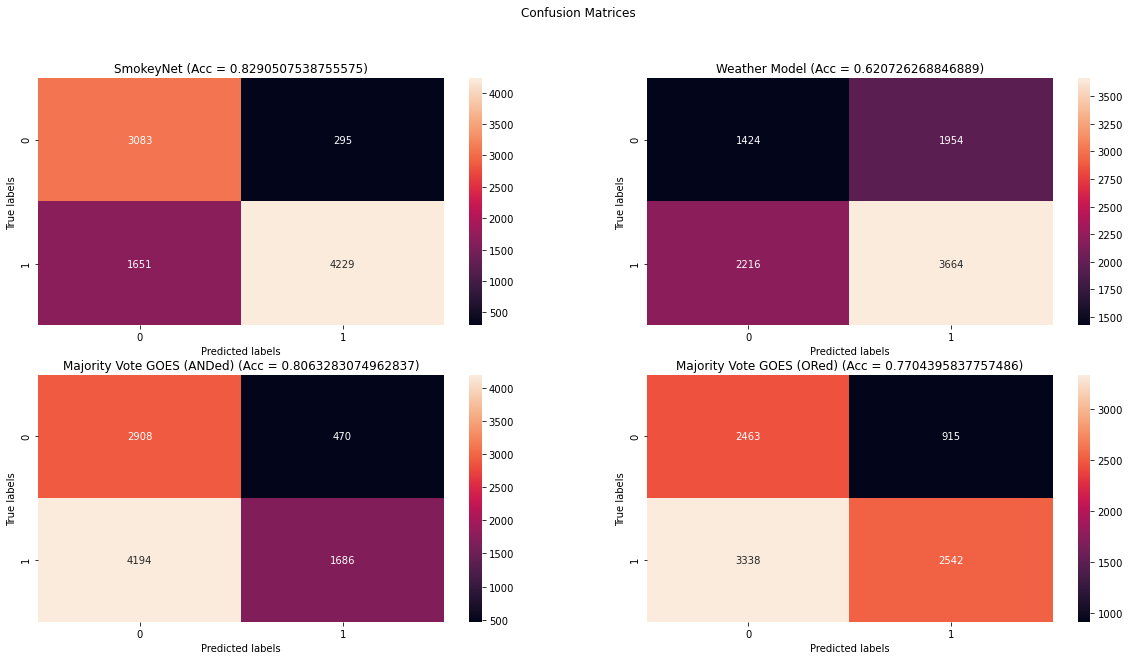

In [142]:
from matplotlib import pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix

# print (help(ConfusionMatrixDisplay))
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 10))
fig.suptitle('Confusion Matrices')
# plt.figure(figsize=[60,60])

sn.heatmap(confusion_matrix(lstm_val_test_df["sequences_gt"], lstm_val_test_df["smokeynet_pred"]), annot=True, fmt='g', ax=ax1)
sn.heatmap(confusion_matrix(lstm_val_test_df["sequences_gt"], lstm_val_test_df.weather_pred), annot=True, fmt='g', ax=ax2)
sn.heatmap(confusion_matrix(lstm_val_test_df["sequences_gt"], lstm_val_test_df.goes_and), annot=True, fmt='g', ax=ax3)
sn.heatmap(confusion_matrix(lstm_val_test_df["sequences_gt"], lstm_val_test_df.goes_or), annot=True, fmt='g', ax=ax4)

# labels, title and ticks
ax1.set_xlabel('Predicted labels')
ax1.set_ylabel('True labels') 
ax1.set_title('SmokeyNet (Acc = 0.8290507538755575)')
ax2.set_xlabel('Predicted labels')
ax2.set_ylabel('True labels') 
ax2.set_title('Weather Model (Acc = 0.620726268846889)')
ax3.set_xlabel('Predicted labels')
ax3.set_ylabel('True labels') 
ax3.set_title('Majority Vote GOES (ANDed) (Acc = 0.8063283074962837)')
ax4.set_xlabel('Predicted labels')
ax4.set_ylabel('True labels') 
ax4.set_title('Majority Vote GOES (ORed) (Acc = 0.7704395837757486)')